In [6]:
%matplotlib inline
from __future__ import division, print_function
from matplotlib import pyplot as plt
import numpy as np
from ipywidgets import interact

In [7]:
def play(bandits, n_repetitions, mu, metric='average', noise=.3):
    mu_star = np.max(mu)
    rewards = {name: np.zeros(n_repetitions) for name in bandits}
    for i in range(n_repetitions):
        for name, bandit in bandits.items():
            arm = bandit.play()
            rewards[name][i] = mu[arm]
            bandit.feedback(arm, np.clip(mu[arm] + noise * np.random.randn(), 0, 1))
    plt.hold(True)
    for name, reward in rewards.items():
        if metric == 'regret':
            data = mu_star - reward
        elif metric == 'cumulative':  # Also known as total regret.
            data = np.cumsum(mu_star - reward)
        else:
            assert metric == 'average'
            data = np.cumsum(mu_star - reward) / np.linspace(1, n_repetitions, n_repetitions)
        plt.plot(data, '--', label=name)
    plt.legend()
    plt.show()

In [8]:
class EpsGreedy:
    def __init__(self, n_arms, eps=0):
        self.eps = eps
        self.n_arms = n_arms
        self.payoffs = np.zeros(n_arms)
        self.n_plays = np.zeros(n_arms)
    
    def play(self):
        # Note that the theory tells us to pick epsilon as O(1/t), not constant (which we use here).
        idx = np.argmin(self.n_plays)
        if self.n_plays[idx] == 0:
            return idx
        if np.random.rand() <= self.eps:
            return np.random.randint(self.n_arms)
        else:
            return np.argmax(self.payoffs / self.n_plays)

    def feedback(self, arm, reward):
        self.payoffs[arm] += reward
        self.n_plays[arm] += 1

In [9]:
class UCB:
    def __init__(self, n_arms, tau):
        self.n_arms = n_arms
        self.means = np.zeros(n_arms)
        # Note that the UCB1 algorithm has tau=1.
        self.n_plays = np.zeros(n_arms)
        self.tau = tau
        self.t = 0
    
    def play(self, plot=False):
        # If plot is true, it will plot the means + bounds every 100 iterations.
        self.t += 1
        idx = np.argmin(self.n_plays)
        if self.n_plays[idx] == 0:
            return idx
        ub = self.tau * np.sqrt(2 * np.log(self.t) / self.n_plays)
        ucb = self.means + ub
        if plot and self.t % 100 == 0:
            plt.errorbar(list(range(self.n_arms)), self.means, yerr=ub)
            plt.show()
            print('chose arm', np.argmax(ucb))
        return np.argmax(ucb)

    def feedback(self, arm, reward):
        self.n_plays[arm] += 1
        self.means[arm] += 1 / (self.n_plays[arm]) * (reward - self.means[arm])

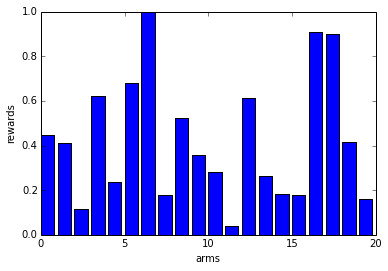

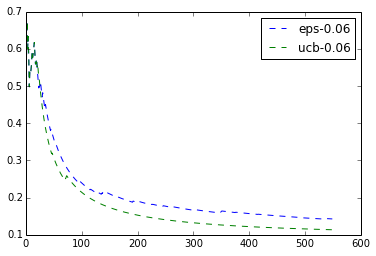

In [10]:
@interact(n_arms=(10, 30, 1), n_rounds=(100, 1000, 10), eps=(0, 1, .01) , tau=(0, 1, .01))
def run(n_arms, n_rounds, eps, tau):
    np.random.seed(123)
    mu = np.random.randn(n_arms)
    # Some other strategies for sampling.
    # mu = np.random.standard_cauchy(n_arms)
    # mu = np.random.gamma(shape=.1, size=(n_arms, 1))
    mu = np.abs(mu)
    mu /= np.max(mu)
    plt.bar(list(range(n_arms)), mu)
    plt.xlabel('arms')
    plt.ylabel('rewards')
    plt.show()
    bandits = {
        'eps-{0}'.format(eps) : EpsGreedy(n_arms, eps=eps),
        'ucb-{0}'.format(tau) : UCB(n_arms, tau=tau)
    }
    play(bandits, n_rounds, mu)
    # Hint: You can also plot the upper bound from UCB1 and see how tight it is.